# Anamorphosis

<!-- SUMMARY: An example for Gaussian Anamorphosis -->

<!-- CATEGORY: Basic_Objects -->

## Import packages

In [2]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc

gdoc.setNoScroll()

<IPython.core.display.Javascript object>

## Reading data

The data are stored in a CSV format in the file called Pollution.dat. We concentrate on the varibale named **Pb**.

In [3]:
filepath = gdoc.loadData("Pollution", "Pollution.dat")
mydb = gl.Db.createFromCSV(filepath,gl.CSVformat())
mydb.setLocators(["X","Y"],gl.ELoc.X)
mydb.setLocator("Pb",gl.ELoc.Z)

dbfmt = gl.DbStringFormat.createFromFlags(flag_vars=True, flag_extend=True, flag_stats=True,
                                         names=["*Pb"]) 
mydb.display(dbfmt)


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Total number of samples      = 102

Data Base Extension
-------------------
Coor #1 - Min =    109.850 - Max =    143.010 - Ext = 33.16
Coor #2 - Min =    483.660 - Max =    513.040 - Ext = 29.38

Data Base Statistics
--------------------
5 - Name Pb - Locator z1
 Nb of data          =        102
 Nb of active values =        101
 Minimum value       =      3.000
 Maximum value       =     31.600
 Mean value          =      6.104
 Standard Deviation  =      3.594
 Variance            =     12.916

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = X - Locator = x1
Column = 2 - Name = Y - Locator = x2
Column = 3 - Name = Zn - Locator = NA
Column = 4 - Name = Pb - Locator = z1


We denote that one sample has no value defined: therefore only 101 values are available. Moreover, the following histogram shows the presence of two outliers (value above 24).

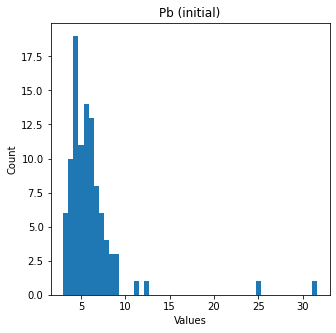

In [4]:
ax = gp.histogram(mydb, name="Pb", bins=50)
ax.decoration(title="Pb (initial)")

We decide to mask these two outliers off. This is an opportunity to create a selection applied on the Data Base.

In [5]:
tab = mydb.getColumn("Pb")
iuid = mydb.addSelection(tab<24)

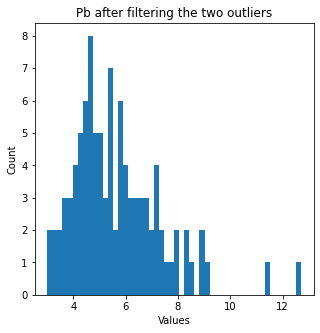

In [6]:
ax = gp.histogram(mydb, name="Pb", bins=50)
ax.decoration(title="Pb after filtering the two outliers")

The updated statistics show that the active values of the variable Pb now vary between 3 and 12.7. Note the variance of the Pb variable is equal to 2.881 (instead of 12.9 prior to masking the outliers off).

In [7]:
mydb.display(dbfmt)


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 6
Total number of samples      = 102
Number of active samples     = 99

Data Base Extension
-------------------
Coor #1 - Min =    109.850 - Max =    143.010 - Ext = 33.16
Coor #2 - Min =    483.660 - Max =    513.040 - Ext = 29.38

Data Base Statistics
--------------------
5 - Name Pb - Locator z1
 Nb of data          =        102
 Nb of active values =         99
 Minimum value       =      3.000
 Maximum value       =     12.700
 Mean value          =      5.658
 Standard Deviation  =      1.697
 Variance            =      2.881

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = X - Locator = x1
Column = 2 - Name = Y - Locator = x2
Column = 3 - Name = Zn - Locator = NA
Column = 4 - Name = Pb - Locator = z1
Column = 5 - Name = NewSel - Locator = sel


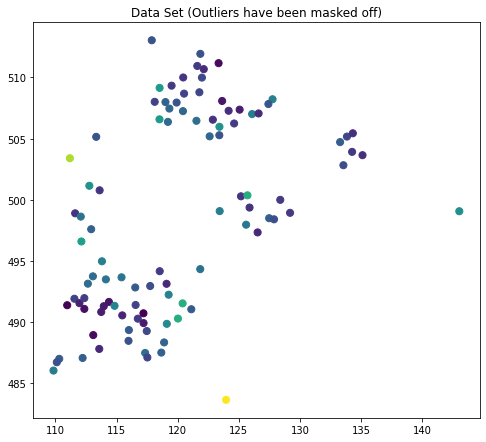

In [8]:
ax = mydb.plot(nameColor="Pb",size=50)
ax.decoration(title="Data Set (Outliers have been masked off)")
plt.show()

## Variograms

We first define the geometry of the variogram calculations

In [9]:
myVarioParamOmni = gl.VarioParam()
mydir = gl.DirParam.create(npas=10, dpas=1.)
myVarioParamOmni.addDir(mydir)

We calculate the experimental omni-directional variogram

In [10]:
myvario = gl.Vario(myVarioParamOmni)
err = myvario.compute(mydb,gl.ECalcVario.VARIOGRAM)

The variogram is represented graphically. 

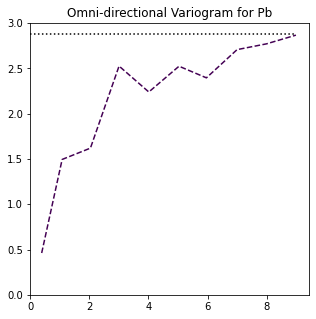

In [11]:
ax = myvario.plot()
ax.decoration(title="Omni-directional Variogram for Pb")

## Model

Fitting a Model. We call the Automatic Fitting procedure providing the list of covariance functions to be tested.

In [12]:
mymodel = gl.Model.createFromDb(mydb)
err = mymodel.fit(myvario,[gl.ECov.EXPONENTIAL,gl.ECov.SPHERICAL])

Visualizing the resulting model, overlaid on the experimental variogram

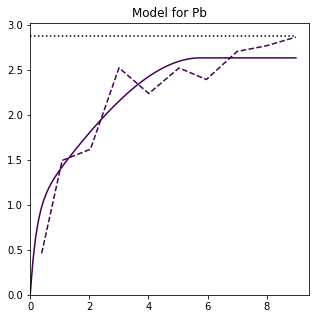

In [13]:
ax = gp.varmod(myvario,mymodel)
ax.decoration(title="Model for Pb")

In [14]:
mymodel.setDriftIRF()
mymodel.display()


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 2
Number of drift function(s)  = 1
Number of drift equation(s)  = 1

Covariance Part
---------------
Exponential
- Sill         =      0.966
- Range        =      0.637
- Theo. Range  =      0.212
Spherical
- Sill         =      1.670
- Range        =      5.757
Total Sill     =      2.637

Drift Part
----------
Universality_Condition


## Empirical Anamorphosis

We first perform the simplest Anamorphosis transform which turns the histogram of the raw variable into the histogram of a gaussian variable. This is done by **comparing** the cumulated density functions.

In [15]:
myanamE = gl.AnamEmpirical()
myanamE.fitFromLocator(mydb)
myanamE.display()


Empirical Anamorphosis
----------------------
Number of discretization lags = 99

Discretization Intervals
------------------------
          Z          Y
      4.600     -0.583
      4.500     -0.706
      4.700     -0.468
      5.400     -0.025
      4.200     -0.954
      5.100     -0.151
      5.000     -0.228
      6.200      0.468
      6.300      0.553
      6.200      0.496
      6.000      0.358
      4.900     -0.332
      3.300     -1.881
      3.600     -1.476
      4.900     -0.305
      4.400     -0.772
      6.200      0.524
      5.500      0.050
      8.000      1.282
      4.300     -0.878
      4.700     -0.440
      7.100      0.915
      4.200     -0.915
      7.200      0.994
      8.300      1.405
      8.000      1.341
      4.500     -0.674
      6.000      0.385
      8.500      1.555
      7.200      1.036
      6.300      0.583
      6.400      0.613
      4.900     -0.279
      3.900     -1.175
      4.800     -0.358
      3.400     -1.645
      3.000     

## Gaussian Anamorphosis

We transform the Data into Gaussian. This requires the definition of a transform function called **Gaussian Anamophosis**. This function is expanded on a basis of Hermite polynomials: here 30 polynomials are used.

In [ ]:
myanam = gl.AnamHermite(30)
myanam.fitFromLocator(mydb)
myanam.display()

We can produce the Gaussian Anamorphosis graphically within its definition domain.

In [ ]:
ax = gp.anam(myanam)
ax.decoration(title="Anamorphosis")

The next step consists in translating the target variable ('Pb') into its Gaussian transform. We can check that the newly created variable is centered with a mean close to 0 and a variance close to 1.

In [ ]:
err = myanam.rawToGaussianByLocator(mydb)
mydb.display(dbfmt)

The histogram of the transformed values show the expected beel shape.

In [ ]:
ax = gp.histogram(mydb, name="Y.Pb", bins=50)

## Variogram in the Gaussian scale

We calculate the experimental (omni-directional) variogram on the Gaussian transformed variable.

In [ ]:
myvarioG = gl.Vario(myVarioParamOmni)
err = myvarioG.compute(mydb,gl.ECalcVario.VARIOGRAM)

We fit the model by automatic fit. In some cases, it is required the resulting model to have its sill equal to 1: this constraints is added to the fitting step;

In [ ]:
mymodelG = gl.Model.createFromDb(mydb)
constr = gl.Constraints(1)
err = mymodelG.fit(myvarioG,[gl.ECov.EXPONENTIAL], constr)
ax = gp.varmod(myvarioG,mymodelG)
ax.decoration(title="Model for Gaussian Pb")

## Back transform from Gaussian to Raw scale

We turn the Gaussian values back to the Raw scale. This exercise is not very demonstrative when based on the initial data themselves: in operational framework, we use this transform to turn newly created values in the Gaussian scale (results of Simulations for example) back in the Raw scale.

In [ ]:
myanam.gaussianToRaw(mydb,"Y.Pb")
mydb.display(dbfmt)

The back transformation, from Gaussian to Raw scale, is performed using the Hermite polynomial expansion (with a limited number of polynomials). This is the reason why we may expect each datum not to coincide exactly with its initial value. This is demonstrated in the next correlation plot.

In [ ]:
ax = gp.correlation(mydb, namex="Pb", namey="Z.Y.Pb", asPoint=True)